In [24]:
import os
from turtle import title
import matplotlib.pyplot as plt
import numpy as np
from fears.utils import results_manager, dir_manager, stats, plotter
import pandas as pd
import pickle

os.chdir('/Users/kinge2/repos/seascapes_figures')

exp_info_path = 'results/results_09282023_0003/experiment_info_09282023_0003.p'
xmin = 4*24
xmax = 21*24

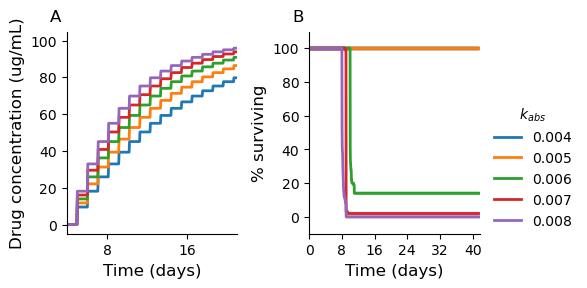

In [25]:
resistance_outcome = [1,2]

roc_exp = pickle.load(open(exp_info_path,'rb'))

data_folder = roc_exp.results_path
exp_info_file = roc_exp.experiment_info_path

exp_folders,exp_info = results_manager.get_experiment_results(exp=roc_exp)

n_sims = exp_info.n_sims
k_abs = exp_info.slopes

pop = exp_info.populations[0]

# fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(8,2.5))
fig,ax_list = plt.subplots(ncols=2,figsize=(6,3))

ax = ax_list[0]

xticks = np.arange(0,pop.n_timestep,24*8)

indx = 0
for p in exp_info.populations:
    ax.plot(p.drug_curve,linewidth=2,label='$k_{abs}$ = ' + str(p.k_abs))
    
    ax.set_xticks(xticks)

    ax = plotter.x_ticks_to_days(p,ax)
    ax.set_xlim([xmin,xmax])
    indx+=1

# ax.legend(frameon=False,fontsize=10)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlabel('Time (days)',fontsize=12)
ax.set_ylabel('Drug concentration (ug/mL)',fontsize=12)

ax.annotate('A',xy=(-0.1,1.05),xycoords='axes fraction',fontsize=12)

ax = ax_list[1]

km_data = stats.km_curve(exp=roc_exp,resistance_outcome=resistance_outcome)
prop_data1 = stats.n_mut_curve(exp=roc_exp,nmut=1)
prop_data2 = stats.n_mut_curve(exp=roc_exp,nmut=2)
prop_data3 = stats.n_mut_curve(exp=roc_exp,nmut=3)
prop_data4 = stats.n_mut_curve(exp=roc_exp,nmut=4)

max_idx_dict = stats.most_freq_genotype(exp=roc_exp,mode=None)

tmax = int(pop.n_timestep)

for k_abs in km_data.keys():
    
    exp_dict = km_data[k_abs]

    death_event_times = exp_dict['survival']

    ax = plotter.plot_kaplan_meier(pop,death_event_times,
                                        ax=ax,
                                        n_sims=n_sims,
                                        label=k_abs,
                                        mode='survival',
                                        t_max=tmax,
                                        linewidth=2)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

pad = 0.05

ax.set_ylabel('% surviving',fontsize=12)
ax.set_xlabel('Time (days)',fontsize=12)

# ax.set_title('Survival of infectious agent',fontsize=12)

ax.set_ylim([-10,110])

ax.set_xticks(xticks)

ax = plotter.x_ticks_to_days(pop,ax)

# ax.set_xlim([xmin,xmax])

ax.legend(frameon=False,fontsize=10,loc=(1.05,0),title='$k_{abs}$')

ax.annotate('B',xy=(-0.1,1.05),xycoords='axes fraction',fontsize=12)

fig.tight_layout()

fig.savefig('figures/roc_km.pdf',bbox_inches='tight')

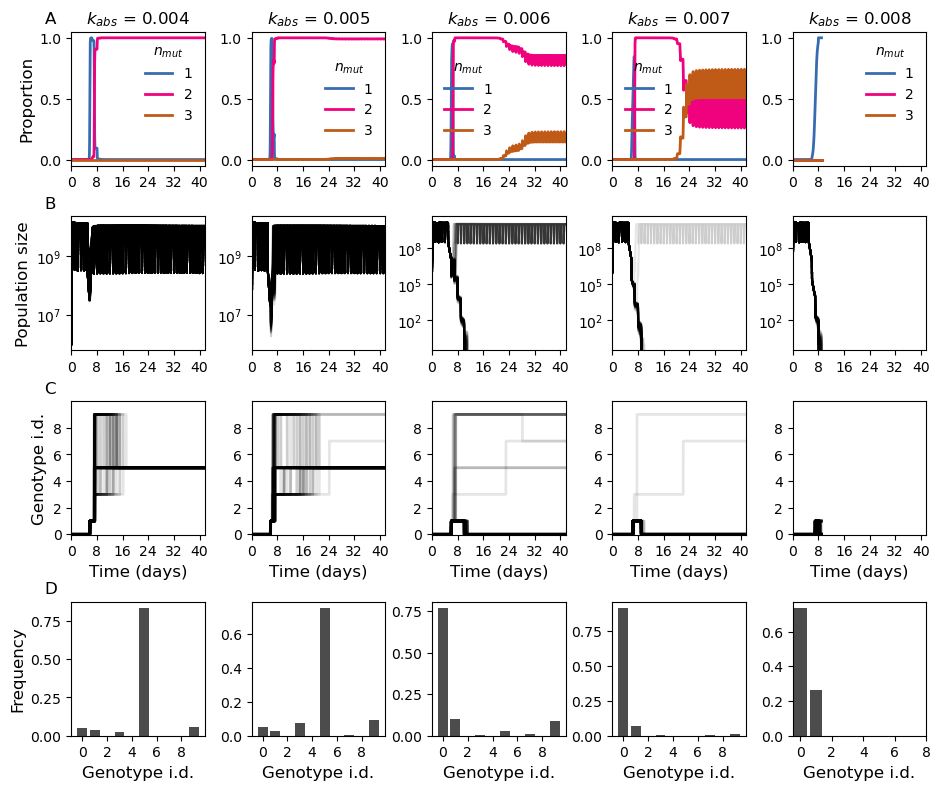

In [26]:
n_conditions = len(km_data.keys())
fig,ax_list = plt.subplots(nrows=4,ncols=n_conditions,figsize=(2*n_conditions,8),
                            sharex=False,sharey=False)

cmap = plt.get_cmap('Accent')

indx = 0
for key in prop_data1.keys():
    ax = ax_list[0,indx]

    ax.plot(prop_data1[key],label='1',linewidth=2,color=cmap(4))
    ax.plot(prop_data2[key],label='2',linewidth=2,color=cmap(5))
    ax.plot(prop_data3[key],label='3',linewidth=2,color=cmap(6))

    ax.set_ylim([-0.05,1.05])

    # ax.set_yscale('symlog',linthresh=0.1)

    ax.set_xticks(xticks)

    ax = plotter.x_ticks_to_days(pop,ax)

    ax.set_xlim([xmin,xmax])
    ax.set_title('$k_{abs}$ = ' + key,fontsize=12)

    ax.legend(frameon=False,title='$n_{mut}$',fontsize=10)

    ax = ax_list[1,indx]


    for sim_num in range(n_sims):
        y = stats.get_population_timetrace(sim_num=sim_num,condition_num=indx,exp=roc_exp)
        ax.plot(y,color='black',alpha=0.1)
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0,pop.n_timestep,24*10))
    ax = plotter.x_ticks_to_days(pop,ax)
    
    ax = ax_list[2,indx]

    max_idx = max_idx_dict[key]

    for i in range(max_idx.shape[1]):
        ax.plot(max_idx[:,i],linewidth=2,color='k',alpha=0.1)

    ax.set_yticks(np.arange(0,10,2))

    ax.set_ylim([-0.05,10])

    ax.set_xlabel('Time (days)',fontsize=12)
    
    ax = ax_list[3,indx]

    max_idx = max_idx[xmin:,:]

    max_idx = max_idx.flatten()

    # ax.hist(max_idx,bins=np.arange(0,10,1),color='k',alpha=0.7,density=True,
    #         align='mid',rwidth=0.8)

    labels, counts = np.unique(max_idx, return_counts=True)
    counts = counts/np.sum(counts)
    ax.bar(labels, counts, align='center',color='k',alpha=0.7)

    # ax.set_xticks(np.arange(0,10,2)+0.5)

    # xl = list(np.arange(0,10,2).astype(int).astype(str))
    ax.set_xticks(np.arange(0,10,2))
    # ax.set_xticklabels(np.arange(0,10,2))
    ax.set_xlabel('Genotype i.d.',fontsize=12)

    indx+=1

xticks = np.arange(0,pop.n_timestep,24*8)

for ax in ax_list[0:3,:].flatten():
    ax.set_xticks(xticks)

    ax = plotter.x_ticks_to_days(pop,ax)

    # ax.set_xlim([xmin,xmax])

ax_list[0,0].set_ylabel('Proportion',fontsize=12)
ax_list[1,0].set_ylabel('Population size',fontsize=12)
ax_list[2,0].set_ylabel('Genotype i.d.',fontsize=12)
ax_list[3,0].set_ylabel('Frequency',fontsize=12)

ax_list[0,0].legend(frameon=False,fontsize=10,title='$n_{mut}$')

labels = ['A','B','C','D']

indx = 0
for ax in ax_list[:,0]:
    ax.annotate(labels[indx],xy=(-0.2,1.06),xycoords='axes fraction',
                fontsize=12)
    indx+=1

for row in range(ax_list.shape[0]):
    for col in range(ax_list.shape[1]):
        ax = ax_list[row,col]
        pos = ax.get_position()
        pos.x0 += 0.02*col
        pos.x1 += 0.02*col

        pos.y0 -= 0.03*row
        pos.y1 -= 0.03*row
        ax.set_position(pos)

for ax in ax_list[-1,:]:
    pos = ax.get_position()
    pos.y1 -= 0.02
    pos.y0 -= 0.02
    ax.set_position(pos)

fig.savefig('figures/roc_grid.pdf',bbox_inches='tight')
# fig.tight_layout()